# Objective: Indentify which quantitative metrics are correlated (or well-predicted) with the human score in Likert scale. 

  - 1. ANOVA (variance analysis). Helps to verify whether the differences in the metric produce significant differences in the rating.
  - 2. Analysis of correlation between each metric and rating (average values) (Spearman and/or Kendall).
  - 3. Optionally, to model the relation between metric and rating, ordinal regression or linear regression if Likert is considered continuous.

**Experiments Scenarios**:
1. "Passing"
2. "Overtaking"
3. "Crossing 1"
4. "Crossing 2"
5. "Advanced 1"
6. "Advanced 2"
7. "Advanced 3"
8. "Advanced 4"

**Labels**:
1. "Good"
2. "Mid"
3. "Bad"

**QM Metrics**
- [0] Time to Goal
- [1] Path length
- [2] Cumulative heading changes
- [3] Avg robot linear speed
- [4] Social Work 
- [5] Social Work (per second)
- [6] Average minimum distance to closest person
- [7] Proxemics: intimate space occupancy
- [8] Proxemics: personal space occupancy
- [9] Proxemics: social space occupancy
- [10] Proxemics: public space occupancy

**HM Metrics**
- [0] Unobtrusiveness
- [1] Friendliness
- [2] Smoothness
- [3] Avoidance Foresight

Therefore we have 24 scenarios. 11 cuantitative metrics and 4 Likert-scale metric of 70 users. 

First, we load the data:

In [43]:
import yaml
import numpy as np
import os
from os.path import expanduser

In [44]:
home = expanduser("~")
# Load config params for experiments
config = yaml.safe_load(open('params.yaml'))['social_metrics_match']

lab_data_path = home + config['data']['repo_dir'] + config['data']['lab_data_path']
survey_data_path = home + config['data']['repo_dir'] + config['data']['survey_data_path']
results_dir = home + config['data']['results_path']
print("lab data path: ", lab_data_path)
print("survey data path: ", survey_data_path)
print("results dir path: ", results_dir)

# normalize Likert scale from 1-5 to 0-1
normalizeHM = True
# normalize quantitative metrics
normalizeQM = True
# weight the qualitative metrics according to robotics expertise
weightQual = False

lab data path:  /root/Social-Nav-Metrics-Matching/social_metrics_match/data_folder/validation_of_metrics_quantitative_and_lab_qualitative.ods
survey data path:  /root/Social-Nav-Metrics-Matching/social_metrics_match/data_folder/qualitative_metrics_survey.xlsx
results dir path:  /root/social_metrics_results


## Extract LAB data arrays

In [45]:
from utils.data_organization import organize_dict_lab_data, get_all_lab_data_arr, np_extract_exp_lab, np_single_lab_run
from utils.data_organization  import organize_dict_survey, weighted_avg_survey_data, get_robotics_knowledge, datacube_qual_survey_data

In [46]:
dict_lab_data = organize_dict_lab_data(lab_data_path)
print(f"Lab data keys: {dict_lab_data.keys()}")
print(f"Lab data keys for passing: {dict_lab_data['Passing'].keys()}")
print(f"Lab data keys for pasing-good-qualitative: {dict_lab_data['Passing']['Good']['qualitative']['friendliness']}")

# Starting from the complete dataframe with lab data, Extract the np arrays of all lab scenarios dividing QM and HM
all_lab_QM_array, all_lab_HM_array = get_all_lab_data_arr(dict_lab_data, normalizeQM=normalizeQM, normalizeHM=normalizeHM, normalization="rescale")
all_lab_QM_nonorm_array, all_lab_HM_nonorm_array = get_all_lab_data_arr(dict_lab_data, normalizeQM=normalizeQM, normalizeHM=normalizeHM, normalization="rescale")
# print(f"All lab QM array: {all_lab_QM_array.shape}, All lab HM array: {all_lab_HM_array.shape}")
# print(f"All lab QM nonorm array: {all_lab_QM_nonorm_array}, All lab HM nonorm array: {all_lab_HM_nonorm_array}")

Lab data keys: dict_keys(['Passing', 'Overtaking', 'Crossing 1', 'Crossing 2', 'Advanced 1', 'Advanced 2', 'Advanced 3', 'Advanced 4'])
Lab data keys for passing: dict_keys(['Good', 'Mid', 'Bad'])
Lab data keys for pasing-good-qualitative: 4


**SURVEY DATA**

In [47]:
dict_survey_data = organize_dict_survey(survey_data_path)
robot_knowledge_array = get_robotics_knowledge(survey_data_path)

# To extract np arrays of all the survey data
survey_datacube = datacube_qual_survey_data(dict_survey_data, normalize=normalizeHM)

# To directly extract the average and std: If Weighted average set w_avg=True (use robotics background knowledge as weights)
survey_array_avg, survey_array_std = weighted_avg_survey_data(dict_survey_data, robot_knowledge_array, w_avg=weightQual, normalize=normalizeHM)
print(f"survey avg shape: {survey_array_avg.shape},\nsurvey weighted std shape:  {survey_array_std.shape}") 
print(f"survey avg[0]: {survey_array_avg[0]},\nsurvey weighted std[0]:  {survey_array_std[0]}")

survey avg shape: (24, 4),
survey weighted std shape:  (24, 4)
survey avg[0]: [0.36231884 0.44927536 0.50434783 0.47246377],
survey weighted std[0]:  [0.19934781 0.22173439 0.21157435 0.25474287]


# Step 1: Non-parametric correlations (Spearman and Kendall)

In [48]:
from scipy import stats

# All lab QM array: (24, 11), All lab HM array: (24, 4)
# Now, we compare each metric with the survey data for each of the 4 criteria
# example dict_spearman = {'social_work': {'friendliness': {'rho': 0.5, 'p': 0.6}}}
# example dict_kendall = {'social_work': {'friendliness': {'tau': 0.5, 'p': 0.6}}}
metrics = ['Time-to-Goal', 'Path-Length', 'Cum-heading', 'Avg-robot-vel', 'Social-Work', 'Social-Work-sec', 'Avg-min-dist-person', 'Proxemics-intimate', 'Proxemics-personal', 'Proxemics-social', 'Proxemics-public']
criterias = dict_lab_data['Passing']['Good']['qualitative'].keys()
dict_spearman = {} 
dict_kendall = {}
# weighted_survey_array_avg shape: (24, 4)

for i, metric in enumerate(metrics):
    dict_spearman[metric] = {}
    dict_kendall[metric] = {}
    for j, criteria in enumerate(dict_lab_data['Passing']['Good']['qualitative'].keys()):
        # Spearman correlation
        rho, pval = stats.spearmanr(all_lab_QM_array[:, i], survey_array_avg[:,j])
        dict_spearman[metric][criteria] = {}
        dict_spearman[metric][criteria]['rho'] = rho
        dict_spearman[metric][criteria]['p'] = pval
        # Kendall correlation
        tau, pval = stats.kendalltau(all_lab_QM_array[:, i], survey_array_avg[:,j])
        dict_kendall[metric][criteria] = {}
        dict_kendall[metric][criteria]['tau'] = tau
        dict_kendall[metric][criteria]['p'] = pval

# Print the results
print("Spearman correlation results:")
for metric, criteria_dict in dict_spearman.items():
    for criteria, result in criteria_dict.items():
        print(f"{metric} - {criteria}: rho = {result['rho']}, p-value = {result['p']}")

print("\n\n")

print("Kendall correlation results:")
for metric, criteria_dict in dict_kendall.items():
    for criteria, result in criteria_dict.items():
        print(f"{metric} - {criteria}: tau = {result['tau']}, p-value = {result['p']}")


Spearman correlation results:
Time-to-Goal - unobtrusiveness: rho = 0.2407293314367301, p-value = 0.25715794794124464
Time-to-Goal - friendliness: rho = 0.3995376782006841, p-value = 0.053079736281745296
Time-to-Goal - smoothness: rho = 0.5207967552973263, p-value = 0.009072427301832582
Time-to-Goal - avoidance foresight: rho = 0.5306498209361635, p-value = 0.007636441199190348
Path-Length - unobtrusiveness: rho = 0.05452984855749134, p-value = 0.8002159247801649
Path-Length - friendliness: rho = -0.006201249994245652, p-value = 0.9770574596392909
Path-Length - smoothness: rho = 0.10212135439900782, p-value = 0.6349097583973466
Path-Length - avoidance foresight: rho = -0.11738080346250697, p-value = 0.5848993351828223
Cum-heading - unobtrusiveness: rho = 0.2828458811356055, p-value = 0.18049787013537733
Cum-heading - friendliness: rho = 0.16167544627854735, p-value = 0.4503996744174622
Cum-heading - smoothness: rho = 0.4027258618164777, p-value = 0.05103858799870029
Cum-heading - avoid

### Now we check for possible candidates!

Spearman:
- rho [-1,1]: 
    * |rho| > 0.7           -- strong correlation
    * 0.4 < |rho| <= 0.7    -- moderate
    * 0.2 < |rho| <= 0.4    -- light
    * <= 0.2                -- none
- p: if p < 0.05            -- correlation is statistically significant

Kendall:
- tau:
    * |tau| > 0.6           -- strong
    * 0.3 < |tau| <= 0.6    -- moderate
    * 0.1 < |tau| <= 0.3    -- light
    * <= 0.1                -- none
- p: if p < 0.05            -- correlation is statitically significant

In [49]:
# Thresholds to filter strong and significant correlations
SPEARMAN_THRESH = 0.4  # strength
KENDALL_THRESH = 0.25  # strength
PVAL_THRESH = 0.065     # statistical significance

# Filter Results
good_spearman = {}
good_kendall = {}

print("\n📊 Candidate Metrics Correlation according to Spearman:")
for metric, criteria_dict in dict_spearman.items():
    for criteria, result in criteria_dict.items():
        rho, p = result['rho'], result['p']
        if abs(rho) >= SPEARMAN_THRESH and p < PVAL_THRESH:
            print(f"✅ {metric} - {criteria}: rho = {rho:.3f}, p = {p:.3f}")
            good_spearman.setdefault(metric, {})[criteria] = {'rho': rho, 'p': p}

print("\n📊 Candidate Metrics Correlation according to Kendall:")
for metric, criteria_dict in dict_kendall.items():
    for criteria, result in criteria_dict.items():
        tau, p = result['tau'], result['p']
        if abs(tau) >= KENDALL_THRESH and p < PVAL_THRESH:
            print(f"✅ {metric} - {criteria}: tau = {tau:.3f}, p = {p:.3f}")
            good_kendall.setdefault(metric, {})[criteria] = {'tau': tau, 'p': p}



📊 Candidate Metrics Correlation according to Spearman:
✅ Time-to-Goal - smoothness: rho = 0.521, p = 0.009
✅ Time-to-Goal - avoidance foresight: rho = 0.531, p = 0.008
✅ Cum-heading - smoothness: rho = 0.403, p = 0.051
✅ Avg-robot-vel - avoidance foresight: rho = -0.501, p = 0.013
✅ Avg-min-dist-person - unobtrusiveness: rho = 0.494, p = 0.014
✅ Avg-min-dist-person - friendliness: rho = 0.651, p = 0.001
✅ Avg-min-dist-person - smoothness: rho = 0.444, p = 0.030
✅ Avg-min-dist-person - avoidance foresight: rho = 0.638, p = 0.001
✅ Proxemics-intimate - unobtrusiveness: rho = 0.519, p = 0.009
✅ Proxemics-intimate - friendliness: rho = 0.609, p = 0.002
✅ Proxemics-intimate - smoothness: rho = 0.417, p = 0.043
✅ Proxemics-intimate - avoidance foresight: rho = 0.572, p = 0.004
✅ Proxemics-social - unobtrusiveness: rho = 0.462, p = 0.023
✅ Proxemics-social - friendliness: rho = 0.451, p = 0.027
✅ Proxemics-social - avoidance foresight: rho = 0.520, p = 0.009

📊 Candidate Metrics Correlation 

### We cross Spearman and Kendall to find coincidences

In [50]:
# Matching between Spearman and Kendall:
consistent_metrics = {}

print("\n🔁 Matching between Spearman and Kendall:")
for metric in good_spearman:
    if metric in good_kendall:
        for criteria in good_spearman[metric]:
            if criteria in good_kendall[metric]:
                # Ambas pruebas coinciden
                rho = good_spearman[metric][criteria]['rho']
                tau = good_kendall[metric][criteria]['tau']
                print(f"✅ {metric} - {criteria}: rho = {rho:.3f}, tau = {tau:.3f}")
                consistent_metrics.setdefault(metric, {})[criteria] = {
                    'rho': rho,
                    'tau': tau,
                    'spearman_p': good_spearman[metric][criteria]['p'],
                    'kendall_p': good_kendall[metric][criteria]['p']
                }

# To print all the correlation scores:
# import pprint; pprint.pprint(consistent_metrics)



🔁 Matching between Spearman and Kendall:
✅ Time-to-Goal - smoothness: rho = 0.521, tau = 0.356
✅ Time-to-Goal - avoidance foresight: rho = 0.531, tau = 0.359
✅ Cum-heading - smoothness: rho = 0.403, tau = 0.280
✅ Avg-robot-vel - avoidance foresight: rho = -0.501, tau = -0.352
✅ Avg-min-dist-person - unobtrusiveness: rho = 0.494, tau = 0.327
✅ Avg-min-dist-person - friendliness: rho = 0.651, tau = 0.443
✅ Avg-min-dist-person - smoothness: rho = 0.444, tau = 0.299
✅ Avg-min-dist-person - avoidance foresight: rho = 0.638, tau = 0.451
✅ Proxemics-intimate - unobtrusiveness: rho = 0.519, tau = 0.387
✅ Proxemics-intimate - friendliness: rho = 0.609, tau = 0.474
✅ Proxemics-intimate - smoothness: rho = 0.417, tau = 0.288
✅ Proxemics-intimate - avoidance foresight: rho = 0.572, tau = 0.435
✅ Proxemics-social - unobtrusiveness: rho = 0.462, tau = 0.365
✅ Proxemics-social - friendliness: rho = 0.451, tau = 0.344
✅ Proxemics-social - avoidance foresight: rho = 0.520, tau = 0.413


### Store the results in CSV

In [51]:
# We generate a CSV file with the results ordered by strength of correlation
import pandas as pd

# Step 1: Convertir consistent_metrics en lista de filas
rows = []
for metric, crit_dict in consistent_metrics.items():
    for criteria, vals in crit_dict.items():
        strength = (abs(vals['rho']) + abs(vals['tau'])) / 2
        rows.append({
            'metric': metric,
            'criteria': criteria,
            'rho': vals['rho'],
            'tau': vals['tau'],
            'spearman_p': vals['spearman_p'],
            'kendall_p': vals['kendall_p'],
            'strength': strength
        })

# Step 2: Crear DataFrame y ordenar por fuerza de correlación
df_corr = pd.DataFrame(rows)
df_corr_sorted = df_corr.sort_values(by='strength', ascending=False)

# Step 3: Guardar en CSV
df_corr_sorted.to_csv("statistical_analysis_results/correlaciones_consistentes.csv", index=False)

print("\n✅ Save consistent correlations ordered per strength in 'statistical_analysis_results/correlaciones_consistentes.csv'")




✅ Save consistent correlations ordered per strength in 'statistical_analysis_results/correlaciones_consistentes.csv'


### Generate a heatmap of the correlations

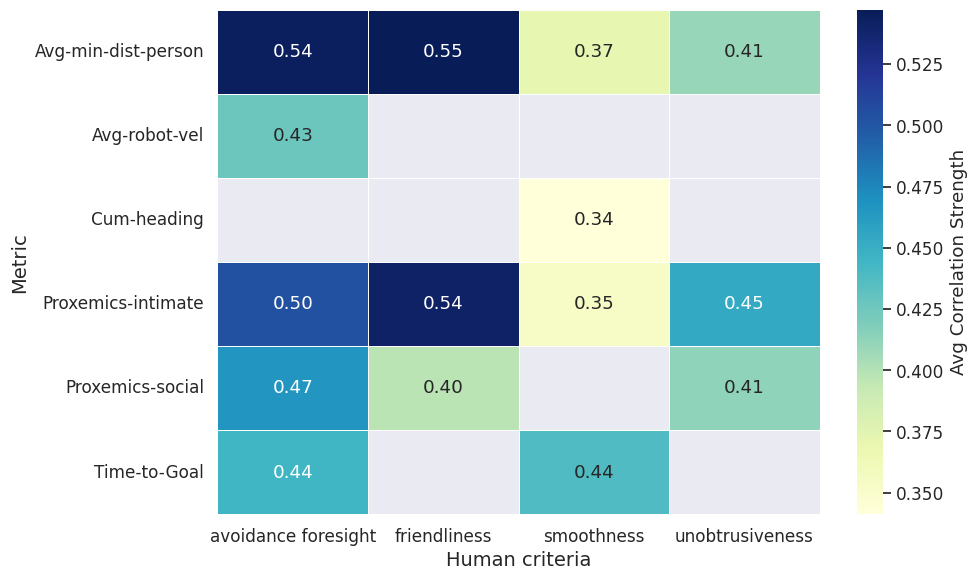

In [52]:
# Generate a heatmap of the correlations
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot from sorted dataframe (rows: metrics, columns: criteria)
heatmap_data = df_corr_sorted.pivot(index='metric', columns='criteria', values='strength')

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.set(font_scale=1.1)
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5, cbar_kws={'label': 'Avg Correlation Strength'})

# plt.title("Consistent correlations", fontsize=14)
plt.ylabel("Metric", fontsize=14)
plt.xlabel("Human criteria", fontsize=14)
plt.tight_layout()

# Save heatmap gifure
plt.savefig("statistical_analysis_results/heatmap_correlaciones.png", dpi=300)
plt.show()


## Step 2: ORDINAL REGRESSION (ideal for Likert)

But we should work with ordinal data (Likert 1-5).
Since we are employing the average values (and normalizing the data in some cases), we do not use the ordinal ones, and we do not apply this.

Instead--> LINEAR REGRESSION (continuous Likert) 


# Code for linear regression with statmodels

- coef → cuánto cambia la valoración por unidad de cambio en la métrica.

- P>|t| → si es < 0.05, se considera que esa métrica está estadísticamente relacionada con el criterio humano.

- R-squared → qué tanto del criterio puede explicarse con las métricas (idealmente cercano a 1).

- const → término independiente (intercepto).

### Consejito:
Si el modelo tiene R² bajo y muchos p-valores > 0.05, puede que haya mucho ruido, o que no todas las métricas sean relevantes.
Puedes seleccionar solo métricas significativas o hacer regularización (Lasso, Ridge) si hay multicolinealidad.

In [53]:
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [54]:
import statsmodels.api as sm
import pandas as pd

# Nombres opcionales
criteria_names = criterias
metrics_names = metrics

# Convertimos X a DataFrame para claridad en nombres de variables
X = pd.DataFrame(all_lab_QM_array, columns=metrics_names)

for i, crit in enumerate(criteria_names):
    y = survey_array_avg[:, i]

    # Añadimos intercepto manualmente
    X_with_const = sm.add_constant(X)

    model = sm.OLS(y, X_with_const)
    result = model.fit()

    print(f"\n📊 Regresión lineal para criterio: {crit}")
    print(result.summary())



📊 Regresión lineal para criterio: unobtrusiveness
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     2.087
Date:                Wed, 30 Apr 2025   Prob (F-statistic):              0.111
Time:                        12:27:09   Log-Likelihood:                 11.462
No. Observations:                  24   AIC:                             1.077
Df Residuals:                      12   BIC:                             15.21
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

El siguiente script will do:

- Ajustará una regresión lineal con todas las métricas.

- Revisará los p-valores de cada coeficiente.

- Filtrará solo las métricas significativas (p < 0.05).

- Ajustará un nuevo modelo solo con esas métricas.

- Mostrará un resumen limpio del resultado final y lo guardará en un archivo csv.

In [55]:
import statsmodels.api as sm
import pandas as pd

# Nombres
# Nombres opcionales
criteria_names = criterias
metrics_names = metrics

results_list = []

# DataFrame con nombres
X = pd.DataFrame(all_lab_QM_array, columns=metrics_names)

for i, crit in enumerate(criteria_names):
    y = survey_array_avg[:, i]

    # Primer modelo con todas las métricas
    X_with_const = sm.add_constant(X)
    model_full = sm.OLS(y, X_with_const).fit()

    # Filtrar métricas con p < 0.05
    significant_vars = model_full.pvalues[model_full.pvalues < 0.05].index
    significant_vars = significant_vars.drop('const', errors='ignore')

    print(f"\n📊 Regresión para '{crit}' con métricas significativas:")
    if len(significant_vars) == 0:
        print("⚠️ No hay métricas significativas con p < 0.05")
    else:
        # Crear nuevo modelo con solo las variables significativas
        X_sig = sm.add_constant(X[significant_vars])
        model_sig = sm.OLS(y, X_sig).fit()
        print(model_sig.summary())

        # Guardar coeficientes y p-valores
        for var in significant_vars:
            results_list.append({
                'criterion': crit,
                'metric': var,
                'coef': model_sig.params[var],
                'p_value': model_sig.pvalues[var]
            })

if(len(results_list) > 0):
    # Convertir a DataFrame
    results_df = pd.DataFrame(results_list)
    # Guardar en CSV
    results_df.to_csv("statistical_analysis_results/regression_results.csv", index=False)
    print("\n✅ Resultados de regresión guardados en 'regression_results.csv'")



📊 Regresión para 'unobtrusiveness' con métricas significativas:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     1.730
Date:                Wed, 30 Apr 2025   Prob (F-statistic):              0.202
Time:                        12:27:09   Log-Likelihood:               -0.46042
No. Observations:                  24   AIC:                             4.921
Df Residuals:                      22   BIC:                             7.277
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

Plot the importance of the metrics (absolute coefficient)

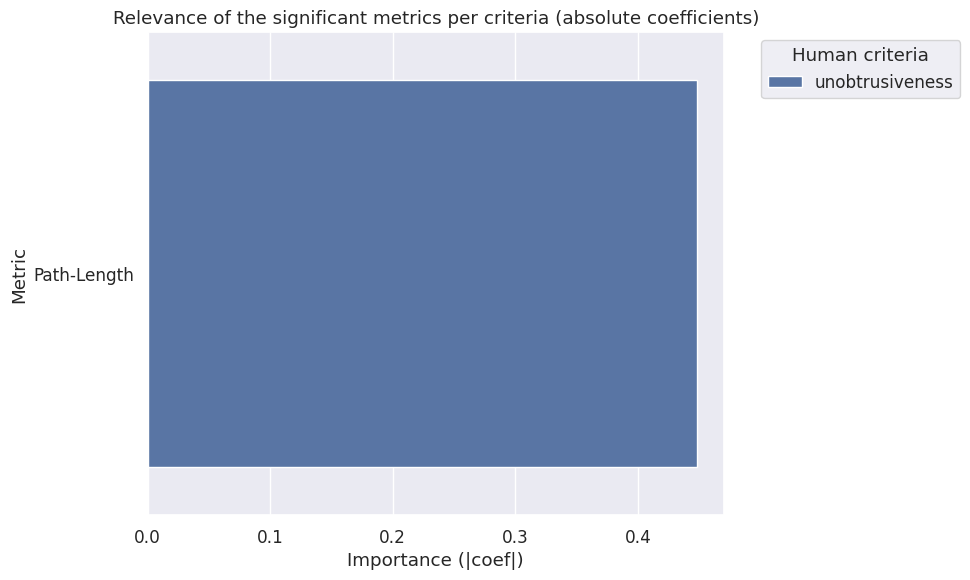

📷 Gráfico guardado como 'importancia_metricas.png'


In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

# Asegúrate de tener df_results del bloque anterior
if(len(results_list) > 0):
    # Creamos columna para importancia (valor absoluto del coeficiente)
    results_df['importance'] = results_df['coef'].abs()

    # Hacemos una gráfica por criterio
    plt.figure(figsize=(10, 6))
    sns.barplot(data=results_df, x='importance', y='metric', hue='criterion', dodge=True)

    plt.title("Relevance of the significant metrics per criteria (absolute coefficients)")
    plt.xlabel("Importance (|coef|)")
    plt.ylabel("Metric")
    plt.legend(title="Human criteria", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig("statistical_analysis_results/importancia_metricas.png", dpi=300)
    plt.show()

    print("📷 Gráfico guardado como 'importancia_metricas.png'")
else:
    print("⚠️ No hay métricas significativas para graficar.")


# Result analysis

As we can see, Spearman and Kendall suggest several candidates correlated with human ratings. However, the linear regression shows no significant metrics.
This is a very common situation in real-world data analysis, and it can happen for several reasons. Let’s break it down:

✅ **Spearman and Kendall**:
- Measure monotonic correlation, not necessarily linear.

- Don’t assume a linear relationship.

- They are bivariate tests: they assess one metric against one criterion at a time.

❌ **Linear regression** (statsmodels):
- Assumes a linear relationship between metrics and the human criterion.

- It’s a multivariate model: it considers all metrics at once, and each p-value measures whether a metric adds additional explanatory power beyond the others.

- You get p-values for each metric under the assumption that all others are in the model.

### 🚨 So why might you see this discrepancy?

1. **Non-linear relationships**

- There might be a monotonic trend (captured by Spearman/Kendall), but the relationship isn't strictly linear.

- Example: A U-shaped or S-shaped relationship.

2. **Multicollinearity between metrics**

- If your metrics are highly correlated with each other, the regression model can’t separate their effects.

- Result: High p-values, even if some metrics are meaningful on their own.

3. **Small sample size (N = 24)**

- With only 24 samples, the statistical power of the model is low.

- That means it's hard to reach significance (p < 0.05) unless effects are strong.

4. **Noise or inconsistency in human ratings**

- If human evaluations are subjective or inconsistent, that adds noise and weakens the relationship.

### ✅ What can you do about it?

1. **Visualize each relationship**

    Plot each metric against each human criterion using scatterplots, and add linear or non-linear trend lines:

2. **Try non-linear transformations**

    For example: log, squared terms, or polynomial features.

3. **Use more flexible models**

    These can handle non-linear or complex relationships:

    - Random Forest Regressor

    - Gradient Boosting

    - Polynomial Regression

    - Ordinal Regression (especially if the human ratings are ordinal)

 4. **Dimensionality reduction**

    To reduce multicollinearity:

    - *PCA* (Principal Component Analysis)

    - *Lasso Regression* (adds regularization and selects metrics automatically)

### 📌 Summary

|*Method*	            |*What it Measures*	                            |*Limitations*                                      |
|---------------------- |-----------------------------------------------|---------------------------------------------------|
Spearman/Kendall	    |Monotonic bivariate correlation	            |Doesn’t consider linearity or multiple predictors  |
Linear Regression	    |Multivariate linear + significance testing	    |Sensitive to multicollinearity, assumes linearity  |
